# Granular Flow Clogging Simulation

This notebook implements simulation experiments for the project on **Clogging in granular flow through a bottleneck**.

We model the flow of grains through a small orifice using two approaches:

1. **Cellular Automaton (CA) model:** A simple rule-based model representing the granular medium on a 2D lattice. Grains move downward if the cell below is empty or slide diagonally when blocked. We monitor the formation of arch-like structures that block the orifice (clogging) and compute the probability of clogging as a function of the orifice width.

2. **Molecular Dynamics (MD) demonstration:** A small-scale discrete element simulation implemented to illustrate the physical interactions between soft disks in a rectangular hopper. Although limited in size, this simulation demonstrates how grains interact with each other and with container walls.

The simulations produce visualisations and quantitative results that will be used in the project report.


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [2]:

# Cellular Automaton (CA) functions

def run_ca(grid_w=10, grid_h=30, orifice_w=2, max_steps=200, drop_rate=3):
    # Simulate granular flow on a 2D lattice using simple rules.
    grid = np.zeros((grid_h, grid_w), dtype=int)
    orifice_start = (grid_w - orifice_w) // 2
    orifice_end = orifice_start + orifice_w
    jam_counter = 0
    removed_count = 0
    for step in range(max_steps):
        # add new grains at the top
        for _ in range(drop_rate):
            col = random.randint(0, grid_w-1)
            if grid[grid_h-1, col] == 0:
                grid[grid_h-1, col] = 1
        moved = False
        new_grid = grid.copy()
        # update from row 1 to top
        for row in range(1, grid_h):
            for col in range(grid_w):
                if grid[row, col] == 1:
                    # attempt to move down
                    if new_grid[row-1, col] == 0 and (row-1 > 0 or (orifice_start <= col < orifice_end)):
                        new_grid[row-1, col] = 1
                        new_grid[row, col] = 0
                        moved = True
                    else:
                        # try diagonal moves
                        dirs = [-1, 1]
                        random.shuffle(dirs)
                        for dc in dirs:
                            c2 = col + dc
                            if 0 <= c2 < grid_w and new_grid[row-1, c2] == 0 and (row-1 > 0 or (orifice_start <= c2 < orifice_end)):
                                new_grid[row-1, c2] = 1
                                new_grid[row, col] = 0
                                moved = True
                                break
        # discharge grains at the orifice
        for c in range(orifice_start, orifice_end):
            if new_grid[0, c] == 1:
                new_grid[0, c] = 0
                removed_count += 1
                moved = True
        grid = new_grid
        # check for an arch spanning the orifice in the row above the exit
        if np.all(grid[1, orifice_start:orifice_end] == 1):
            jam_counter += 1
        else:
            jam_counter = 0
        if jam_counter >= 5:
            return True, removed_count, step, grid
    return False, removed_count, max_steps, grid


def ca_experiments(orifice_widths, runs=20, grid_w=10, grid_h=30, drop_rate=3, max_steps=300):
    jam_probs = []
    removed_avgs = []
    jam_times = []
    for w in orifice_widths:
        jam_count = 0
        removed_total = 0
        jam_time_total = 0
        for i in range(runs):
            jam, removed, jt, _ = run_ca(grid_w=grid_w, grid_h=grid_h, orifice_w=w, drop_rate=drop_rate, max_steps=max_steps)
            jam_count += 1 if jam else 0
            removed_total += removed
            jam_time_total += jt
        jam_probs.append(jam_count / runs)
        removed_avgs.append(removed_total / runs)
        jam_times.append(jam_time_total / runs)
    return jam_probs, removed_avgs, jam_times


# Dynamic CA run: run until no grains discharge for `stall_steps` iterations (jam) or flow continues

def run_ca_dynamic(grid_w=10, grid_h=30, orifice_w=2, drop_rate=3, stall_steps=50):
    """Run CA until the number of grains discharged stops increasing for `stall_steps` steps.
    Returns: jam (bool), removed_count, steps, final grid."""
    grid = np.zeros((grid_h, grid_w), dtype=int)
    orifice_start = (grid_w - orifice_w) // 2
    orifice_end = orifice_start + orifice_w
    removed_count = 0
    last_removed_step = 0
    step = 0
    while True:
        # add new grains at the top
        for _ in range(drop_rate):
            col = random.randint(0, grid_w - 1)
            if grid[0, col] == 0:
                grid[0, col] = 1
        # move grains from bottom to top
        jammed_row = np.copy(grid)
        for row in range(grid_h-2, -1, -1):
            for col in range(grid_w):
                if grid[row, col] == 1:
                    # check below
                    if row + 1 == grid_h - 1:
                        # bottom row above floor
                        # if within orifice, remove grain
                        if orifice_start <= col < orifice_end:
                            grid[row, col] = 0
                            removed_count += 1
                            last_removed_step = step
                        else:
                            # blocked by floor
                            pass
                    else:
                        if grid[row+1, col] == 0:
                            grid[row+1, col] = 1
                            grid[row, col] = 0
                        else:
                            # try diagonal moves
                            moved = False
                            if col > 0 and grid[row+1, col-1] == 0:
                                grid[row+1, col-1] = 1
                                grid[row, col] = 0
                                moved = True
                            elif col < grid_w-1 and grid[row+1, col+1] == 0:
                                grid[row+1, col+1] = 1
                                grid[row, col] = 0
                                moved = True
        step += 1
        # Stop if flow has stalled for stall_steps steps
        if step - last_removed_step > stall_steps:
            jam = True
            break
        # To avoid infinite loop, also break if step is too large
        if step > 5000:
            jam = False
            break
    return jam, removed_count, step, grid


In [3]:

# Simple Molecular Dynamics (MD) demonstration

def md_demo(D=0.3, N=10, r=0.05, W=1.0, H=1.5, T=1.0, dt=0.001, g=9.81, k=8000):
    m = 1.0
    # initialise positions without overlaps in the top half
    positions = []
    for i in range(N):
        placed = False
        for t in range(2000):
            x = np.random.uniform(-W/2 + r, W/2 - r)
            y = np.random.uniform(H/2, H - r)
            ok = True
            for px, py in positions:
                if (x - px)**2 + (y - py)**2 < (2*r)**2:
                    ok = False
                    break
            if ok:
                positions.append((x, y))
                placed = True
                break
        if not placed:
            positions.append((np.random.uniform(-W/2 + r, W/2 - r), np.random.uniform(H/2, H - r)))
    positions = np.array(positions)
    velocities = np.zeros((N, 2))
    removed = np.zeros(N, dtype=bool)
    steps = int(T / dt)
    for step in range(steps):
        F = np.zeros((N, 2))
        F[:, 1] -= g
        # wall and floor contact
        for i in range(N):
            if removed[i]:
                continue
            x, y = positions[i]
            # left wall
            if x - r < -W/2:
                overlap = - (x - r + W/2)
                F[i, 0] += k * overlap
            # right wall
            if x + r > W/2:
                overlap = (x + r - W/2)
                F[i, 0] -= k * overlap
            # bottom outside orifice
            if y - r < 0 and abs(x) > D/2:
                overlap = - (y - r)
                F[i, 1] += k * overlap
        # interparticle forces
        for i in range(N):
            if removed[i]:
                continue
            for j in range(i+1, N):
                if removed[j]:
                    continue
                dx = positions[j] - positions[i]
                dist = np.hypot(dx[0], dx[1])
                overlap = 2*r - dist
                if overlap > 0:
                    if dist == 0:
                        nvec = np.array([1.0, 0.0])
                    else:
                        nvec = dx / dist
                    F_n = k * overlap
                    F[i] -= F_n * nvec
                    F[j] += F_n * nvec
        velocities += F * dt
        positions += velocities * dt
        for i in range(N):
            if removed[i]:
                continue
            x, y = positions[i]
            if y < -r and abs(x) < D/2:
                removed[i] = True
        if removed.all():
            break
    return positions[~removed], removed.sum(), removed


# Extended MD simulation functions for multiple grains and varying orifice widths

def md_run(N=10, D=0.3, r=0.05, W=1.0, H=1.5, T=0.8, dt=0.002, g=9.81, k=8000):
    """Run a simple MD simulation and return remaining and removed grain counts."""
    import math
    # Initialise positions without overlaps
    positions = []
    velocities = []
    for i in range(N):
        for _ in range(10000):
            x = np.random.uniform(-W/2 + r, W/2 - r)
            y = np.random.uniform(H/2, H - r)
            if all((x - px)**2 + (y - py)**2 >= (2*r)**2 for px, py in positions):
                positions.append([x, y])
                velocities.append([0.0, 0.0])
                break
    positions = np.array(positions)
    velocities = np.array(velocities)
    time_steps = int(T / dt)
    removed = 0
    for t in range(time_steps):
        # gravity
        velocities[:, 1] -= g * dt
        M = len(positions)
        # pairwise interactions
        for i in range(M):
            xi, yi = positions[i]
            for j in range(i + 1, M):
                dx = xi - positions[j, 0]
                dy = yi - positions[j, 1]
                dist_sq = dx * dx + dy * dy
                if dist_sq < (2 * r) ** 2:
                    dist = math.sqrt(dist_sq) if dist_sq > 0 else 1e-8
                    overlap = 2 * r - dist
                    nx = dx / dist
                    ny = dy / dist
                    force = k * overlap
                    fx = force * nx
                    fy = force * ny
                    velocities[i, 0] += fx * dt
                    velocities[i, 1] += fy * dt
                    velocities[j, 0] -= fx * dt
                    velocities[j, 1] -= fy * dt
        # wall and floor collisions
        for i in range(len(positions)):
            x, y = positions[i]
            vx, vy = velocities[i]
            if x - r < -W / 2:
                positions[i, 0] = -W / 2 + r
                velocities[i, 0] = abs(vx)
            if x + r > W / 2:
                positions[i, 0] = W / 2 - r
                velocities[i, 0] = -abs(vx)
            if positions[i, 1] - r < 0:
                if abs(positions[i, 0]) > D / 2:
                    positions[i, 1] = r
                    velocities[i, 1] = abs(velocities[i, 1])
            # damping
            velocities[i] *= 0.999
        # update positions
        positions += velocities * dt
        # removal through orifice
        mask = (positions[:, 1] - r < 0) & (np.abs(positions[:, 0]) <= D / 2)
        if np.any(mask):
            removed += np.sum(mask)
            positions = positions[~mask]
            velocities = velocities[~mask]
        if len(positions) == 0:
            break
    remaining = len(positions)
    return remaining, removed


def md_run_positions(N=10, D=0.3, r=0.05, W=1.0, H=1.5, T=0.8, dt=0.002, g=9.81, k=8000):
    """Run a simple MD simulation and return positions at final time for visualisation."""
    import math
    positions = []
    velocities = []
    for i in range(N):
        for _ in range(10000):
            x = np.random.uniform(-W/2 + r, W/2 - r)
            y = np.random.uniform(H/2, H - r)
            if all((x - px)**2 + (y - py)**2 >= (2*r)**2 for px, py in positions):
                positions.append([x, y])
                velocities.append([0.0, 0.0])
                break
    positions = np.array(positions)
    velocities = np.array(velocities)
    time_steps = int(T / dt)
    for t in range(time_steps):
        velocities[:, 1] -= g * dt
        M = len(positions)
        for i in range(M):
            xi, yi = positions[i]
            for j in range(i + 1, M):
                dx = xi - positions[j, 0]
                dy = yi - positions[j, 1]
                dist_sq = dx * dx + dy * dy
                if dist_sq < (2 * r) ** 2:
                    dist = math.sqrt(dist_sq) if dist_sq > 0 else 1e-8
                    overlap = 2 * r - dist
                    nx = dx / dist
                    ny = dy / dist
                    force = k * overlap
                    fx = force * nx
                    fy = force * ny
                    velocities[i, 0] += fx * dt
                    velocities[i, 1] += fy * dt
                    velocities[j, 0] -= fx * dt
                    velocities[j, 1] -= fy * dt
        for i in range(len(positions)):
            x, y = positions[i]
            vx, vy = velocities[i]
            if x - r < -W / 2:
                positions[i, 0] = -W / 2 + r
                velocities[i, 0] = abs(vx)
            if x + r > W / 2:
                positions[i, 0] = W / 2 - r
                velocities[i, 0] = -abs(vx)
            if positions[i, 1] - r < 0:
                if abs(positions[i, 0]) > D / 2:
                    positions[i, 1] = r
                    velocities[i, 1] = abs(velocities[i, 1])
            velocities[i] *= 0.999
        positions += velocities * dt
        mask = (positions[:, 1] - r < 0) & (np.abs(positions[:, 0]) <= D / 2)
        if np.any(mask):
            positions = positions[~mask]
            velocities = velocities[~mask]
        if len(positions) == 0:
            break
    return positions


# Dynamic MD run: stop when no new discs discharge for `stall_time` seconds or all discs removed

def md_run_dynamic(N=100, D=0.3, r=0.02, W=1.0, H=1.5, dt=0.002, max_time=10.0, stall_time=5.0, g=9.81, k=8000):
    positions = []
    velocities = []
    # initial positions without overlap in top half
    for i in range(N):
        for _ in range(10000):
            x = np.random.uniform(-W/2 + r, W/2 - r)
            y = np.random.uniform(H/2, H - r)
            if all((x - px)**2 + (y - py)**2 >= (2*r)**2 for px, py in positions):
                positions.append([x, y])
                velocities.append([0.0, 0.0])
                break
    positions = np.array(positions)
    velocities = np.array(velocities)
    removed = np.zeros(N, dtype=bool)
    removed_count = 0
    time = 0.0
    last_removed_time = 0.0
    max_steps = int(max_time / dt)
    for step in range(max_steps):
        # apply gravity
        velocities[~removed, 1] -= g * dt
        # compute forces
        F = np.zeros_like(positions)
        # wall and floor reactions
        for i in range(N):
            if removed[i]:
                continue
            x, y = positions[i]
            # left and right walls
            if x - r < -W/2:
                overlap = - (x - r + W/2)
                F[i, 0] += k * overlap
            if x + r > W/2:
                overlap = (x + r - W/2)
                F[i, 0] -= k * overlap
            # floor outside orifice
            if y - r < 0 and abs(x) > D/2:
                overlap = - (y - r)
                F[i, 1] += k * overlap
        # interparticle forces
        for i in range(N):
            if removed[i]:
                continue
            for j in range(i+1, N):
                if removed[j]:
                    continue
                dx = positions[j] - positions[i]
                dist = np.hypot(dx[0], dx[1])
                overlap = 2*r - dist
                if overlap > 0:
                    if dist == 0:
                        n = np.array([1.0, 0.0])
                    else:
                        n = dx / dist
                    F[i] -= k * overlap * n
                    F[j] += k * overlap * n
        # update velocities and positions
        velocities[~removed] += F[~removed] * dt
        positions[~removed] += velocities[~removed] * dt
        # check for discharge
        for i in range(N):
            if removed[i]:
                continue
            x, y = positions[i]
            if y - r < 0 and abs(x) <= D/2:
                removed[i] = True
                removed_count += 1
                last_removed_time = time
        time += dt
        # break if no discharge for stall_time
        if time - last_removed_time > stall_time:
            break
        # break if all discs removed
        if removed_count == N:
            break
    return N - removed_count, removed_count

# Dynamic MD run returning positions

def md_run_positions_dynamic(N=100, D=0.3, r=0.02, W=1.0, H=1.5, dt=0.002, max_time=10.0, stall_time=5.0, g=9.81, k=8000):
    positions = []
    velocities = []
    for i in range(N):
        for _ in range(10000):
            x = np.random.uniform(-W/2 + r, W/2 - r)
            y = np.random.uniform(H/2, H - r)
            if all((x - px)**2 + (y - py)**2 >= (2*r)**2 for px, py in positions):
                positions.append([x, y])
                velocities.append([0.0, 0.0])
                break
    positions = np.array(positions)
    velocities = np.array(velocities)
    removed = np.zeros(N, dtype=bool)
    removed_count = 0
    time = 0.0
    last_removed_time = 0.0
    max_steps = int(max_time / dt)
    for step in range(max_steps):
        velocities[~removed, 1] -= g * dt
        F = np.zeros_like(positions)
        for i in range(N):
            if removed[i]:
                continue
            x, y = positions[i]
            if x - r < -W/2:
                overlap = - (x - r + W/2)
                F[i, 0] += k * overlap
            if x + r > W/2:
                overlap = (x + r - W/2)
                F[i, 0] -= k * overlap
            if y - r < 0 and abs(x) > D/2:
                overlap = - (y - r)
                F[i, 1] += k * overlap
        for i in range(N):
            if removed[i]:
                continue
            for j in range(i+1, N):
                if removed[j]:
                    continue
                dx = positions[j] - positions[i]
                dist = np.hypot(dx[0], dx[1])
                overlap = 2*r - dist
                if overlap > 0:
                    if dist == 0:
                        n = np.array([1.0, 0.0])
                    else:
                        n = dx / dist
                    F[i] -= k * overlap * n
                    F[j] += k * overlap * n
        velocities[~removed] += F[~removed] * dt
        positions[~removed] += velocities[~removed] * dt
        for i in range(N):
            if removed[i]:
                continue
            x, y = positions[i]
            if y - r < 0 and abs(x) <= D/2:
                removed[i] = True
                removed_count += 1
                last_removed_time = time
        time += dt
        if time - last_removed_time > stall_time:
            break
        if removed_count == N:
            break
    # return positions of discs still in hopper
    return positions[~removed]


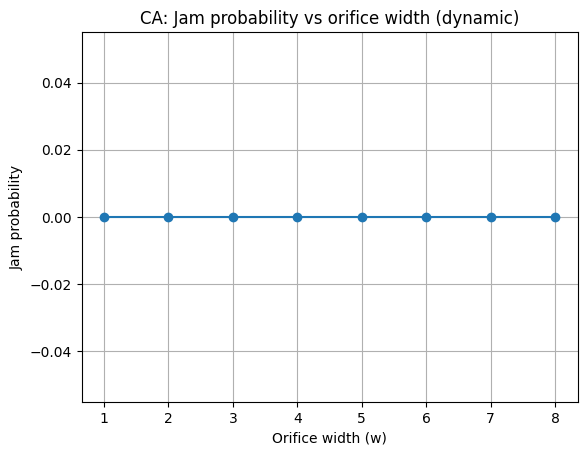

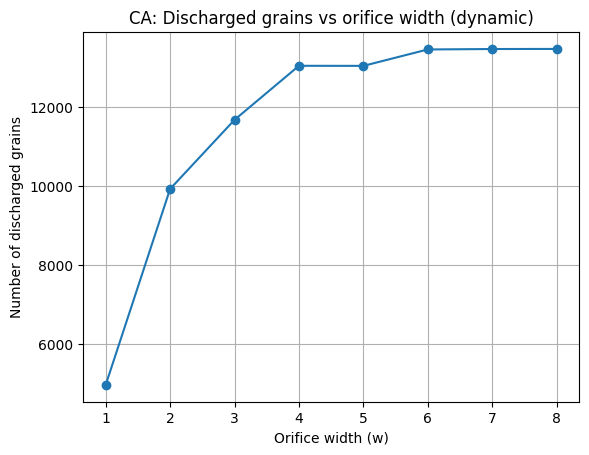

In [4]:

# Run CA experiments for a range of orifice widths using dynamic jam detection
W = 10; H = 30
orifice_widths = list(range(1, 9))
jam_probs = []
avg_removed = []
for w in orifice_widths:
    jam_count = 0
    removed_counts = []
    for _ in range(20):
        jam, removed, steps, grid = run_ca_dynamic(grid_w=W, grid_h=H, orifice_w=w, drop_rate=3, stall_steps=1000)
        jam_count += 1 if jam else 0
        removed_counts.append(removed)
    jam_probs.append(jam_count / len(removed_counts))
    avg_removed.append(np.mean(removed_counts))
# Plot jam probability
plt.figure()
plt.plot(orifice_widths, jam_probs, marker='o')
plt.xlabel('Orifice width (w)')
plt.ylabel('Jam probability')
plt.title('CA: Jam probability vs orifice width (dynamic)')
plt.grid(True)
plt.show()
# Plot discharged grains
plt.figure()
plt.plot(orifice_widths, avg_removed, marker='o')
plt.xlabel('Orifice width (w)')
plt.ylabel('Number of discharged grains')
plt.title('CA: Discharged grains vs orifice width (dynamic)')
plt.grid(True)
plt.show()
# Save the CA plots
plt.figure()
plt.plot(orifice_widths, jam_probs, marker='o')
plt.xlabel('Orifice width (w)')
plt.ylabel('Jam probability')
plt.title('CA: Jam probability vs orifice width (dynamic)')
plt.grid(True)
plt.savefig('fig_ca_jam_prob_more.png', dpi=300)
plt.close()
plt.figure()
plt.plot(orifice_widths, avg_removed, marker='o')
plt.xlabel('Orifice width (w)')
plt.ylabel('Number of discharged grains')
plt.title('CA: Discharged grains vs orifice width (dynamic)')
plt.grid(True)
plt.savefig('fig_ca_removed_more.png', dpi=300)
plt.close()


In [5]:
# (Unused cell removed)

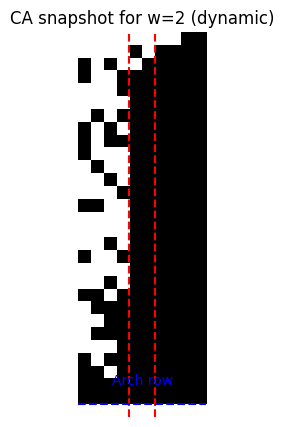

In [6]:

# Generate a sample run and visualise the final grid (for orifice width w=2) with improved annotations
jam, removed, steps, grid = run_ca_dynamic(grid_w=10, grid_h=30, orifice_w=2, drop_rate=3, stall_steps=50)
import matplotlib.colors as colors
plot_grid = np.where(grid == 1, 1, 0)
H, W = grid.shape
w = 2
orifice_start = (W - w) // 2
orifice_end = orifice_start + w
arch_row = H - 2  # row immediately above bottom (indexing from 0)

plt.figure(figsize=(4, 5))
plt.imshow(plot_grid, cmap=colors.ListedColormap(['white','black']), origin='upper')
# draw orifice boundaries
plt.axvline(orifice_start - 0.5, color='red', linestyle='--')
plt.axvline(orifice_end - 0.5, color='red', linestyle='--')
# draw arch location line (row above bottom)
plt.axhline(arch_row + 0.5, color='blue', linestyle='--')
plt.text((orifice_start + orifice_end)/2 - 0.5, arch_row - 1, 'Arch row', color='blue', ha='center')
plt.axis('off')
plt.title('CA snapshot for w=2 (dynamic)')
plt.show()
# Save snapshot
plt.figure(figsize=(4,5))
plt.imshow(plot_grid, cmap=colors.ListedColormap(['white','black']), origin='upper')
plt.axvline(orifice_start - 0.5, color='red', linestyle='--')
plt.axvline(orifice_end - 0.5, color='red', linestyle='--')
plt.axhline(arch_row + 0.5, color='blue', linestyle='--')
plt.text((orifice_start + orifice_end)/2 - 0.5, arch_row - 1, 'Arch row', color='blue', ha='center')
plt.axis('off')
plt.title('CA snapshot for w=2 (dynamic)')
plt.savefig('fig_ca_snapshot_more.png', dpi=300, bbox_inches='tight')
plt.close()


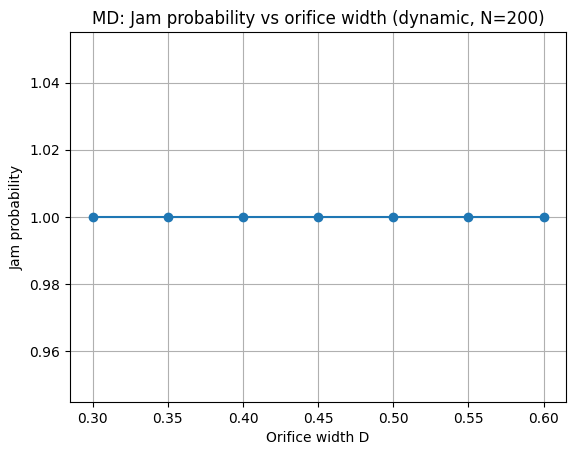

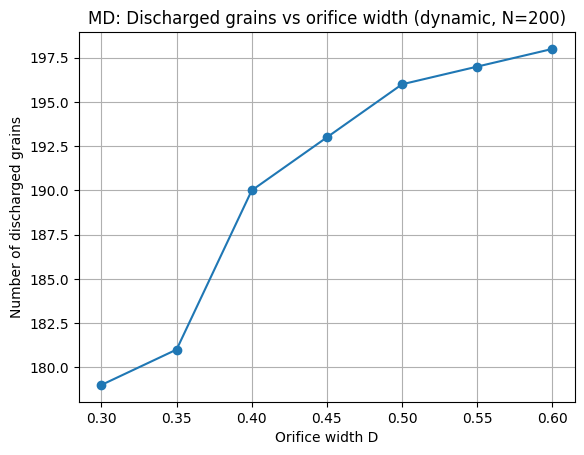

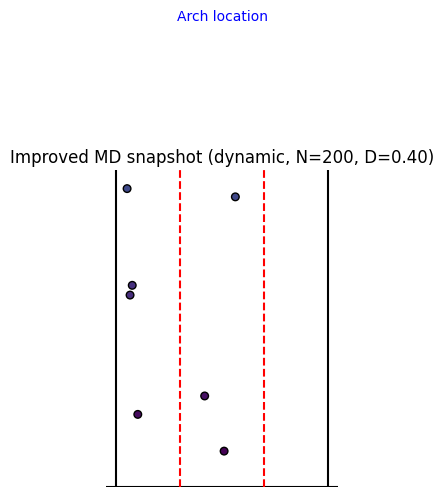

In [7]:

# Demonstrate MD simulation for multiple orifice widths with dynamic jam detection
# Using N=100 grains and orifice widths from 0.30 to 0.60
D_values = [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
md_jam_probs = []
md_removed_avgs = []
for D in D_values:
    # run MD dynamic simulation for each D value
    remaining, removed = md_run_dynamic(N=200, D=D, r=0.02, W=1.0, H=1.5, dt=0.005, max_time=5.0, stall_time=1.0)
    md_jam_probs.append(1 if remaining > 0 else 0)
    md_removed_avgs.append(removed)
# Plot jam probability vs orifice width
plt.figure()
plt.plot(D_values, md_jam_probs, marker='o')
plt.xlabel('Orifice width D')
plt.ylabel('Jam probability')
plt.title('MD: Jam probability vs orifice width (dynamic, N=200)')
plt.grid(True)
plt.show()
# Plot number of discharged grains vs orifice width
plt.figure()
plt.plot(D_values, md_removed_avgs, marker='o')
plt.xlabel('Orifice width D')
plt.ylabel('Number of discharged grains')
plt.title('MD: Discharged grains vs orifice width (dynamic, N=200)')
plt.grid(True)
plt.show()
# Save MD plots
plt.figure()
plt.plot(D_values, md_jam_probs, marker='o')
plt.xlabel('Orifice width D')
plt.ylabel('Jam probability')
plt.title('MD: Jam probability vs orifice width (dynamic, N=200)')
plt.grid(True)
plt.savefig('fig_md_jam_prob_more.png', dpi=300)
plt.close()
plt.figure()
plt.plot(D_values, md_removed_avgs, marker='o')
plt.xlabel('Orifice width D')
plt.ylabel('Number of discharged grains')
plt.title('MD: Discharged grains vs orifice width (dynamic, N=200)')
plt.grid(True)
plt.savefig('fig_md_removed_more.png', dpi=300)
plt.close()
# Generate an improved MD snapshot for D=0.40 using dynamic positions and arch detection
positions = md_run_positions_dynamic(N=200, D=0.40, r=0.02, W=1.0, H=1.5, dt=0.005, max_time=5.0, stall_time=1.0)
W_hopper = 1.0; H_hopper = 1.5; D_snap = 0.40
import matplotlib.cm as cm
plt.figure(figsize=(3, 5))
# draw walls and orifice boundaries
plt.axvline(-W_hopper/2, color='black')
plt.axvline(W_hopper/2, color='black')
plt.axhline(0, color='black')
plt.axvline(-D_snap/2, color='red', linestyle='--')
plt.axvline(D_snap/2, color='red', linestyle='--')
if len(positions) > 0:
    y_norm = positions[:, 1] / H_hopper
    plt.scatter(positions[:, 0], positions[:, 1], s=30, c=y_norm, cmap='viridis', edgecolors='k')
    arch_discs = positions[np.abs(positions[:, 0]) < D_snap/2]
    if len(arch_discs) > 0:
        arch_y = arch_discs[:, 1].max()
        plt.axhline(arch_y, color='blue', linestyle='--')
        plt.text(0, arch_y + 0.02, 'Arch location', color='blue', ha='center')
plt.xlim(-W_hopper/2 - 0.05, W_hopper/2 + 0.05)
plt.ylim(0, H_hopper)
plt.title('Improved MD snapshot (dynamic, N=200, D=0.40)')
plt.axis('off')
plt.gca().set_aspect('equal')
plt.show()
# Save snapshot
plt.figure(figsize=(3,5))
plt.axvline(-W_hopper/2, color='black')
plt.axvline(W_hopper/2, color='black')
plt.axhline(0, color='black')
plt.axvline(-D_snap/2, color='red', linestyle='--')
plt.axvline(D_snap/2, color='red', linestyle='--')
if len(positions) > 0:
    y_norm = positions[:, 1] / H_hopper
    plt.scatter(positions[:, 0], positions[:, 1], s=30, c=y_norm, cmap='viridis', edgecolors='k')
    arch_discs = positions[np.abs(positions[:, 0]) < D_snap/2]
    if len(arch_discs) > 0:
        arch_y = arch_discs[:, 1].max()
        plt.axhline(arch_y, color='blue', linestyle='--')
        plt.text(0, arch_y + 0.02, 'Arch location', color='blue', ha='center')
plt.xlim(-W_hopper/2 - 0.05, W_hopper/2 + 0.05)
plt.ylim(0, H_hopper)
plt.axis('off')
plt.gca().set_aspect('equal')
plt.title('Improved MD snapshot (dynamic, N=200, D=0.40)')
plt.savefig('fig_md_snapshot_more.png', dpi=300, bbox_inches='tight')
plt.close()
